In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import copy

In [2]:
# CHOOSE DATASET

# Binary classification dataset
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 
X.shape

# Keep as DataFrame for named-column ops
df = data.data.copy()
y = np.where(data.target.values == "tested_positive", 1, 0).astype(np.float32)

# indices of features with invalid zeros
invalid_idx = [1, 2, 3, 4, 5, 7]

# count zeros per feature
zero_counts = (X[:, invalid_idx] == 0).sum(axis=0)
rows_with_zero = (X[:, invalid_idx] == 0).any(axis=1).sum()

print("Zeros per feature:\n", zero_counts)
print(f"Rows with ≥1 zero: {rows_with_zero} / {len(df)}")

(len(X), zero_counts, rows_with_zero)

# Drop columns 3 and 4 (0-based indexing)
X = np.delete(X, [3, 4], axis=1)

# Keep only rows where Glucose, BloodPressure, BMI are non-zero
mask = (X[:, [1, 2, 3, 4]] != 0).all(axis=1)
X = X[mask]
y = y[mask]

Zeros per feature:
 [  5  35 227 374  11   0]
Rows with ≥1 zero: 376 / 768


In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [5]:
# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

best_fpc = -1
best_params = None

for n_clusters in np.arange(2, 10, 1):       # number of clusters to test
    for m in np.arange(1.5, 2.5, 0.01): 
    # Fuzzy C-means clustering
        centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            Xexp_T, n_clusters, m, error=0.005, maxiter=1000, init=None,
        )

        if fpc > best_fpc:
            best_fpc = fpc
            best_params = (n_clusters, m)
            

print(best_fpc)
print(best_params[0])
print(best_params[1])

n_clusters=best_params[0]
m=best_params[1]

centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m, error=0.005, maxiter=10000, init=None,
)

0.7231811657391913
2
1.5


In [6]:
centers.shape

(2, 7)

In [7]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.723188876981547


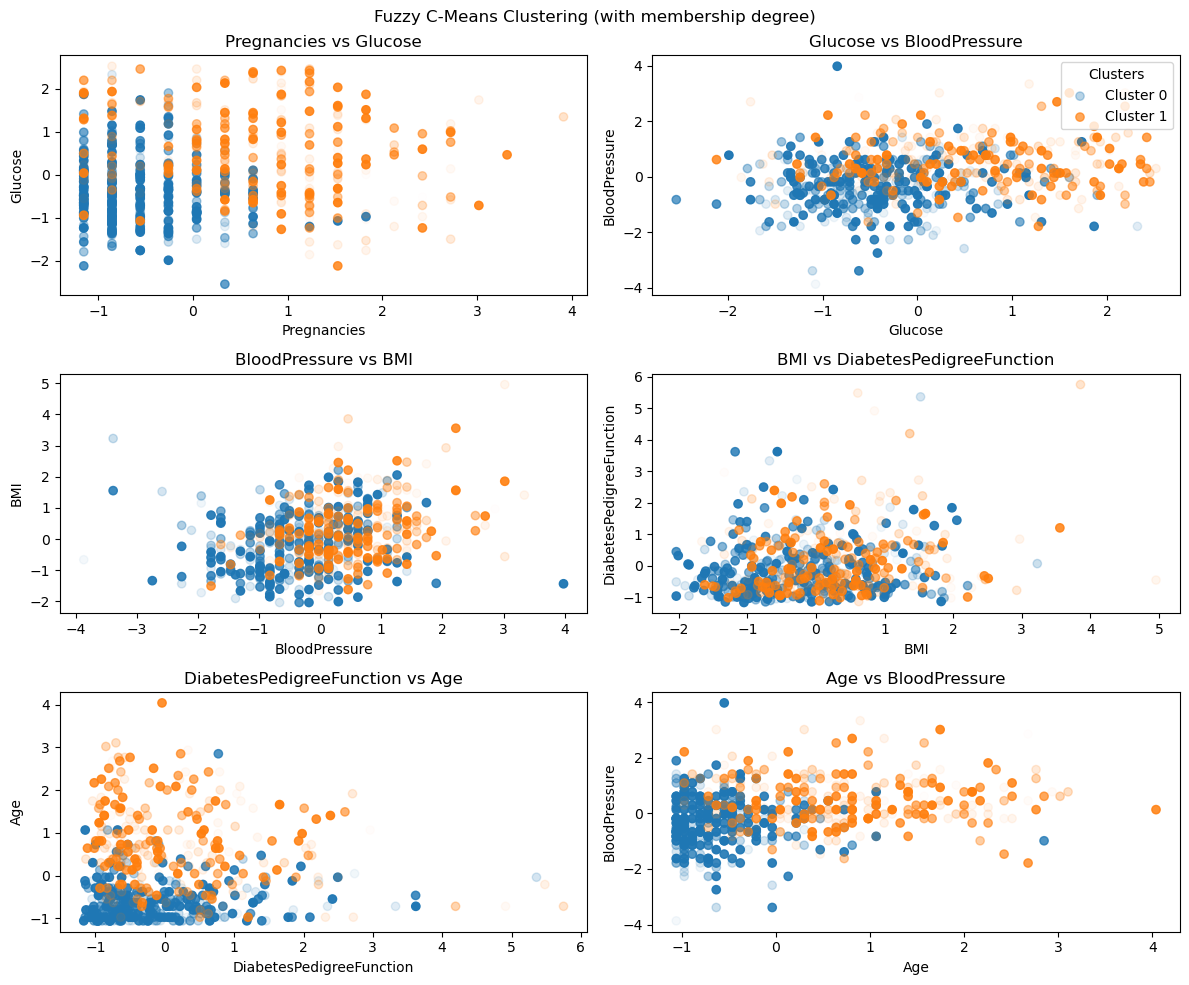

In [8]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

feature_names = [
    "Pregnancies", "Glucose", "BloodPressure",
    "BMI", "DiabetesPedigreeFunction", "Age"
]

# Choose 4 feature pairs (indices in Xexp)
pairs = [(0, 1),  # Pregnancies vs Glucose
         (1, 2),  # Glucose vs BloodPressure
         (2, 3),  # BloodPressure vs BMI
         (3, 4),  # BMI vs Pedigree
         (4, 5),  # Pedigree vs Age
         (5, 2)]  # Age vs Glucose

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, (i, j) in zip(axes.ravel(), pairs):
    # Plot 2 features with fuzzy membership
    for k in range(n_clusters):
        ax.scatter(
            Xexp[cluster_labels == k, i],             # Feature 1
            Xexp[cluster_labels == k, j],             # Feature 2
            alpha=u[k, :],          # transparency ~ membership
            label=f'Cluster {k}'
        )
        
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f"{feature_names[i]} vs {feature_names[j]}")

fig.suptitle("Fuzzy C-Means Clustering (with membership degree)")
axes[0,1].legend(title="Clusters", loc="upper right")
plt.tight_layout()
plt.show()

fig.savefig("Fuzzy C-Means Clustering (with membership degree) CLF.pdf", format="pdf", bbox_inches="tight")

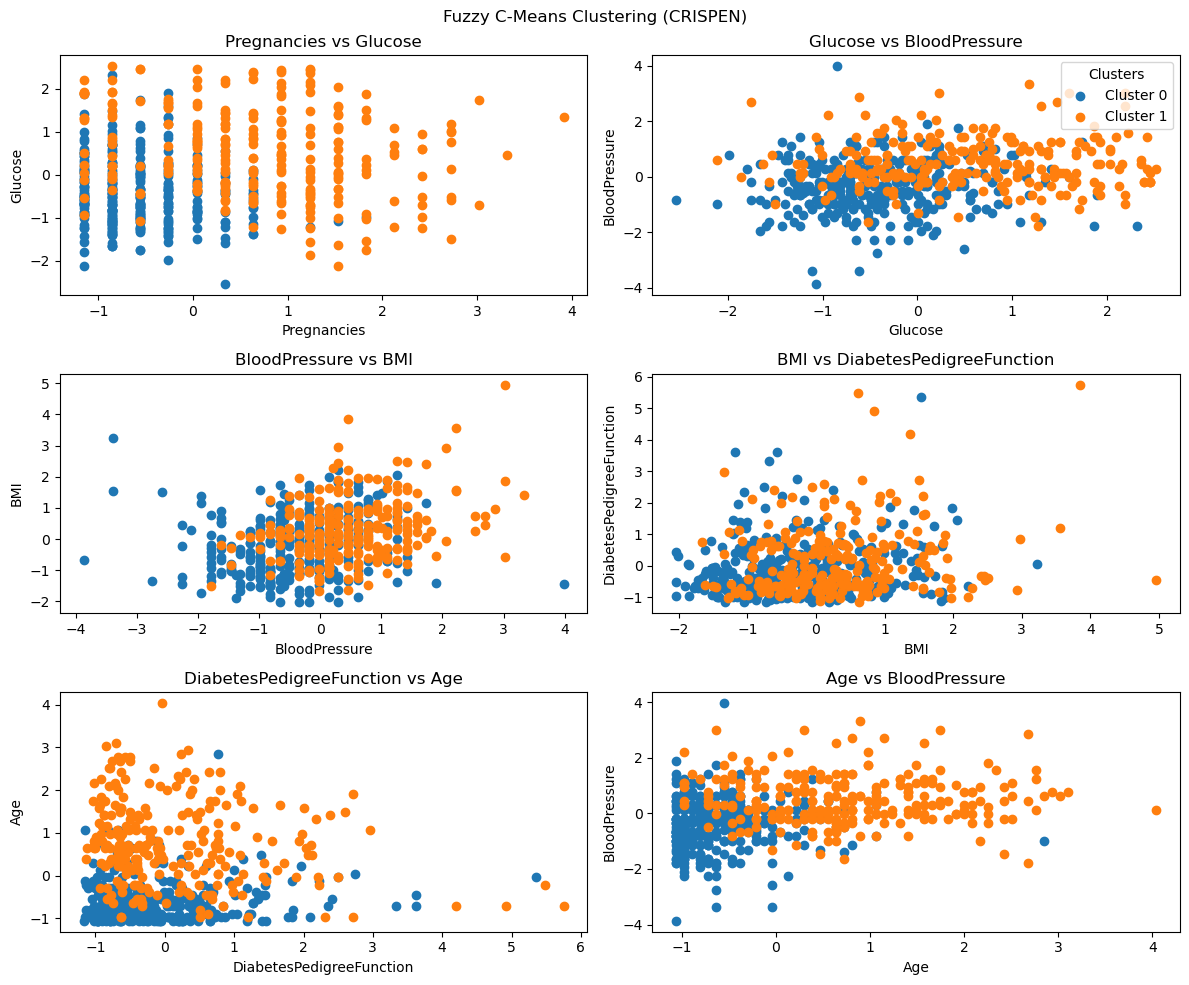

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, (i, j) in zip(axes.ravel(), pairs):
    # Plot 2 features with fuzzy membership
    for k in range(n_clusters):
        ax.scatter(
            Xexp[cluster_labels == k, i],
            Xexp[cluster_labels == k, j],
            label=f'Cluster {k}'
        )
        
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f"{feature_names[i]} vs {feature_names[j]}")

fig.suptitle("Fuzzy C-Means Clustering (CRISPEN)")
axes[0,1].legend(title="Clusters", loc="upper right")
fig.tight_layout()
fig.show()

fig.savefig("Fuzzy C-Means Clustering (CRISPEN) CLF.pdf", format="pdf", bbox_inches="tight")

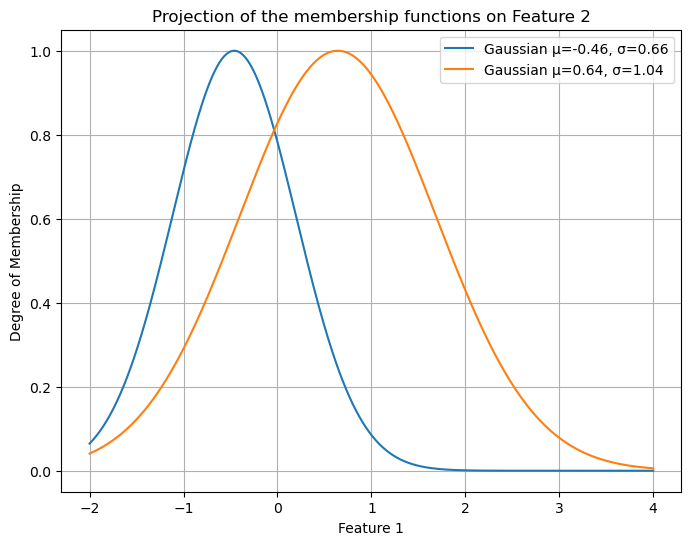

In [10]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [12]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [13]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [14]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [15]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [16]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))

In [17]:
y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}')

ACC:0.8
